<a href="https://colab.research.google.com/github/Barikko/Yandex.Practicum-Projects/blob/main/%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB_%D0%92%D1%8B%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%84%D0%B8%D0%BB%D0%B5%D0%B9_%D0%BF%D0%BE%D1%82%D1%80%D0%B5%D0%B1%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Выявление профилей потребления"

Материалы проекта

Презентация: https://disk.yandex.ru/d/xKfycvCwbBKC7w

Дашборд: https://public.tableau.com/app/profile/aleksandr6311/viz/Final_project_dash_16762983799970/Dashboard1

## Описание проекта:
Интернет-магазину "Пока все ещё тут" необходимо сегментировать покупателей на основе их истории покупок для разработки более персонализированных предложений для покупателей. Заказчик предоставил датасет с транзакциями своего магазина.

##  Описание данных:

Данные хранятся в датасете ecommerce_dataset.csv.
###  Колонки датасета:

    date - дата заказа
    customer_id - идентификатор покупателя
    order_id - идентификатор заказа
    product - наименования товара
    quantity - количество товара в заказе
    price - цена товара

## Загрузка данных и изучение общей информации

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import seaborn as sns
from scipy import stats as st
from PIL import Image

In [2]:
df = pd.read_csv('/content/ecommerce_dataset.csv')

In [3]:
display(df.head(5))
print(df.info())

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB
None


## Предобработка данных

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['total']=df['quantity']*df['price']
df['month'] = df['date'].astype('datetime64[M]')
print("Дубликатов:",df.duplicated().sum())
print("Товаров с отрицательным количеством:",len(df.query("quantity<1")))
print("Товаров с отрицательной ценой:",len(df.query("price<1")))

Дубликатов: 0
Товаров с отрицательным количеством: 0
Товаров с отрицательной ценой: 0


Явных дубликатов не обнаружено, формат даты исправлен на верный, добавлен новый столбец с общим чеком и месяцем.

In [5]:
df = df.drop_duplicates(['customer_id', 'order_id', 'product', 'quantity', 'price'])

## Исследовательский анализ данных

In [6]:
print('Всего покупателей:',len(df['customer_id'].unique()))
print('Всего заказов:',len(df['order_id'].unique()))

Всего покупателей: 2451
Всего заказов: 2784


Покупателей - 2451, заказов - 2784, для более точного исследования сгруппируем данные по заказам и покупателям.

In [7]:
df.describe()

,order_id,quantity,price,total
count,4873.000000,4873.000000,4873.000000,4873.000000
mean,48231.287503,2.837472,514.749846,850.021342
std,27341.349829,17.606813,944.455480,9807.308006
min,12624.000000,1.000000,9.000000,9.000000
25%,14776.000000,1.000000,90.000000,120.000000
50%,68860.000000,1.000000,150.000000,194.000000
75%,70833.000000,1.000000,488.000000,734.000000
max,73164.000000,1000.000000,14917.000000,675000.000000


In [8]:
orders=df.groupby('order_id').agg({'price':'median', 'quantity':'sum', 'total':'sum', 'date':'first','customer_id':'nunique'})
customers = df.groupby('customer_id').agg({'order_id':'nunique', 
                                           'total':'sum', 
                                           'price':'median', 
                                           'quantity':'median', 
                                          })

In [9]:
orders.describe()

,price,quantity,total,customer_id
count,2784.000000,2784.000000,2784.000000,2784.000000
mean,776.792205,4.966595,1487.842672,1.011853
std,1157.857874,24.083546,12964.400709,0.123735
min,11.500000,1.000000,14.000000,1.000000
25%,134.000000,1.000000,292.000000,1.000000
50%,329.000000,1.000000,690.000000,1.000000
75%,974.000000,3.000000,1481.500000,1.000000
max,14917.000000,1000.000000,675000.000000,4.000000


In [10]:
orders

,price,quantity,total,date,customer_id
order_id,,,,,
12624,187.5,2,375.0,2019-06-02 20:00:00,1
13547,207.0,3,684.0,2018-10-05 00:00:00,1
14480,101.0,3,359.0,2018-10-02 11:00:00,1
14481,150.0,4,600.0,2018-10-02 17:00:00,1
14482,188.0,2,376.0,2018-10-07 12:00:00,1
...,...,...,...,...,...
73155,329.0,1,329.0,2019-10-31 11:00:00,1
73156,404.0,1,404.0,2019-10-31 11:00:00,1
73158,1087.0,1,1087.0,2019-10-31 12:00:00,1


Чаще всего заказ содержит 1 предмет со средней ценой в 777 у.е и средним чеком в 1488. Присутствуют и выбросы с 1000 купленных предметов или общим чеком на 675000.

In [11]:
customers.describe()

,order_id,total,price,quantity
count,2451.000000,2451.000000,2451.000000,2451.000000
mean,1.149327,1689.985312,770.949612,3.827213
std,2.655249,14255.913415,1151.877227,24.329600
min,1.000000,14.000000,11.500000,1.000000
25%,1.000000,299.000000,134.000000,1.000000
50%,1.000000,712.000000,337.000000,1.000000
75%,1.000000,1574.000000,974.000000,1.000000
max,126.000000,675000.000000,14917.000000,1000.000000


В основном покупатели совершают одну покупку, средний чек покупателя - 1690, выбросы описаны выше.

Чаще всего покупатель совершает разовую покупку на 1-2 единицы товара и не возвращается в магазин.

In [12]:
customers

,order_id,total,price,quantity
customer_id,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,135.0,1.0
001cee7f-0b29-4716-b202-0042213ab038,1,442.0,442.0,1.0
00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,457.0,2.0
002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1649.0,1.0
003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,1162.0,2.0
...,...,...,...,...
ff601403-b094-4b86-9ac6-264d725b9277,1,1649.0,1649.0,1.0
ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,397.0,397.0,1.0
ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,389.0,389.0,1.0


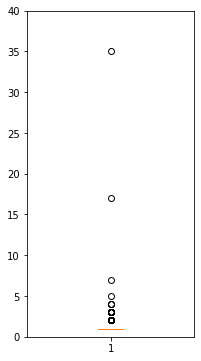

In [13]:
plt.figure(figsize=(3,6))
plt.ylim(0,40)
plt.boxplot(customers['order_id']);

Встречаются выбросы в виде активных покупателей, совершивших >15 или 35 покупок.

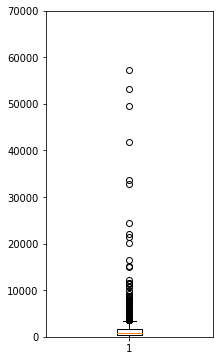

In [14]:
plt.figure(figsize=(3,6))
plt.ylim(0,70000)
plt.boxplot(customers['total']);

Большинство покупателей тратят до 10000 на покупки.

Изучим внимательнее выбросы среди покупателей, создадим датафрейм покупателей, совершивших много заказов и датафрейм покупателей, совершивших заказы на большую сумму.

In [15]:
ano_orders=np.percentile(customers['order_id'], 99)
ano_check=np.percentile(customers['total'], 99)
print('Количество покупок у аномально активных покупателей: >{:.0f}'.format(ano_orders))
print('Аномально большой чек: >{:.0f} у.е.'.format(ano_check))
ano_orders_df = customers.query('order_id>@ano_orders')
ano_check_df = customers.query('total>@ano_check')
print('Количество частых покупателей:',len(ano_orders_df))
print('Количество потратившихся покупателей',len(ano_check_df))

Количество покупок у аномально активных покупателей: >3
Аномально большой чек: >8784 у.е.
Количество частых покупателей: 8
Количество потратившихся покупателей 25


Найдём самую большую покупку:

In [16]:
display(df.query('total==675000'))

,date,customer_id,order_id,product,quantity,price,total,month
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,2019-06-01


Были заказаны 1000 вантузов по цене 675/шт и общим чеком в 675000.

Очистим данные, удалив аномальных пользователей. Также удалим несколько записей, где на один заказ приходится больше одного  уникального пользователя, это ошибка:

In [17]:
x=df.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id>1')
df=df.query('order_id !=71743 & customer_id not in @ano_orders_df & customer_id not in @ano_check_df & order_id not in @x.index')

In [18]:
print('Всего покупателей после очистки данных:',len(df['customer_id'].unique()))
print('Всего заказов после очистки данных:',len(df['order_id'].unique()))

Всего покупателей после очистки данных: 2393
Всего заказов после очистки данных: 2754


## Сегментация покупателей на основе анализа истории их покупок

Сегментируем пользователей по двум параллельным признакам: количество покупок (3 сегмента: 1 покупка, 2-3, более 3) и категория покупаемого товара. Для второй сегментации сначала разделим товары вручную на категории.

### Разделение товаров на категории

Создание категорий:

In [19]:
plants = ['растение','рассада','пеларгония','помидор', 'герань','петуния','горшке','бакопа',
          'кассете','калибрахоа', 'базилик', 'петрушка', 'томат', 'кашпо',
          'лобелия', 'фуксия', 'вербена', 'цветк', 'смесь', "микс", 'земляника', 
          'клубника', 'ель', 'упаков', 'укроп', 'd-', 'камнеломка', 'примула',
          'вербейник', 'колокольчик', 'цикламен', 'барвинок', 'дыня', 'овсянница',
          'папоротник', 'кипарис', 'бегония', 'осина', 'арбуз','черенок',' г ','46500914']
house = ['покрытие', 'почтов', 'чехол','ковр', 'ткан', 'штор', 'ковер','термометр', 
         'ковёр', 'светил', 'весы','одеял', 'простын', 'подуш', 'плед', 'матрас', 'покрывало', 
             'спальн', 'наволочка','халат','полки', 'вешал', 'плечики', 'стеллаж', 'хранен', 
         'крючок', "этажерка", 'комод', 'подставка', 'полка', 'кофр', 'лоток','муляж',
         'искусственн','корыт', 'таз', 'контейнер', 'бак ', 'мусор', 'ведр', 'урна',
         'корзин', 'бидон', 'ковш', 'коробка', 'емкость','фен','ключница','маска','шило','подголовник',
         'фоторамка']
tools = ['инструмент', 'сверел', 'сверло', 'напильник', 'стремянк', 'стяжк', 'шпингалет', 
              'сварка', 'миксер', 'крепеж', 'пружин', 'петл', 'линейк', 'гои','сумка', 'тележ','блок','скоба',
         'шпагат','штангенциркуль','1201']
cleaning = ['тряп', 'швабр', 'перчат','совок', 'гладил', 'глажен', 'прищеп', 'налет', 
            'антижир', 'пылесос', 'крем', 'стир', 'щетка', 'сушилк', 'веник', 
            'подрукавник', 'совком', 'для чистки', 'стирки', 'мыть', 'средство',
            'мойк','мыло','ёрш', 'ерш', 'зуб', 'вантуз']
kitchen = ['блюдо','ванн','сковород','вилка','тарелк', 'ложка','фужер','посуд', 'кувшин', 'противень', 
               'соковыжим','лопатка', 'стакан','салатн','нож', 'бокал','чай','столов','банка','круж', 
               'толкушка','терка', 'варка','масл', 'чистка', 'салфет', 'кастрюл', 'webber','сахар', 
               'котел','wilmax', 'половник','скатерть', 'кипят','дозатор','зажиг','губка спираль', 
               'миска', 'термос', 'хлебница','кухон', 'кухн', 'бульон', 'выпеч', 'пресс', 'блюд',
           'полотен','электроштопор','доска','орехоколка','картофелемялка','скалка']

### Присвоение категорий

Функция для определения категории:

In [20]:
df['category'] = 'Другое'
def cat(arr, category):
    arr1 = '|'.join(arr)
    x = df[df['product'].str.lower().str.contains(arr1)].index.to_list()
    for i in x:
        df.loc[i, 'category'] = category
    return df

cat(plants, 'Растения')
cat(house, 'Товары для дома')
cat(tools, 'Инструменты')
cat(cleaning, 'Клининг')
cat(kitchen, 'Кухня')

<ipython-input-20-c65be5b8c38d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = 'Другое'


,date,customer_id,order_id,product,quantity,price,total,month,category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10-01,Растения
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10-01,Растения
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10-01,Растения
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10-01,Растения
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10-01,Растения
...,...,...,...,...,...,...,...,...,...
6731,2019-10-31 11:00:00,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,329.0,2019-10-01,Растения
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.0,404.0,2019-10-01,Товары для дома
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,1087.0,2019-10-01,Инструменты
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.0,157.0,2019-10-01,Растения


### Изучение категорий

In [21]:
df.groupby('category').agg({'product':'count','price':'median','total':'median','quantity':'mean'})\
.sort_values(by = 'product',ascending=False)

,product,price,total,quantity
category,,,,
Растения,2200,134.0,135.0,1.575455
Кухня,956,209.0,432.0,2.635983
Товары для дома,683,187.0,382.0,4.878477
Клининг,472,562.0,614.0,2.063559
Инструменты,452,1087.0,1087.0,4.707965
Другое,43,105.0,112.0,2.023256


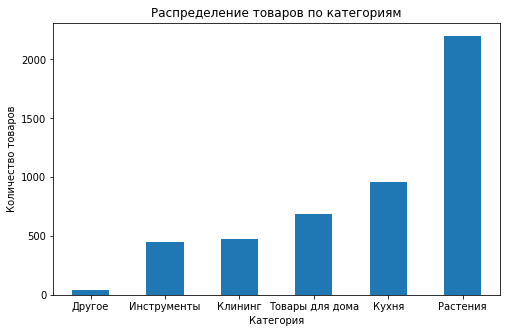

In [22]:
df.pivot_table(index = 'category',values='product', aggfunc='count')\
.sort_values(by='product',ascending = True).plot(kind='bar', title='Распределение товаров по категориям',\
xlabel='Категория',ylabel='Количество товаров', figsize=(8,5),legend = False)
plt.xticks(rotation=0);

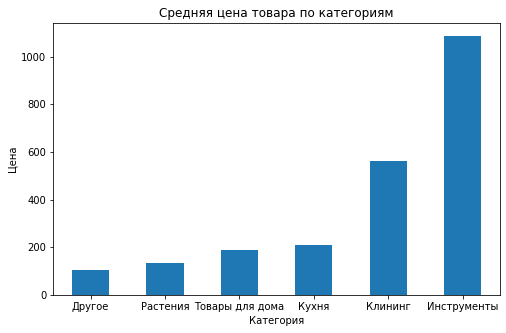

In [23]:
df.pivot_table(index = 'category',values='price', aggfunc='median')\
.sort_values(by='price',ascending = True).plot(kind='bar', title='Средняя цена товара по категориям',\
xlabel='Категория',ylabel='Цена', figsize=(8,5), legend = False)
plt.xticks(rotation=0);

In [24]:
df.groupby('category').agg({'product':'count','price':'median','total':'median','quantity':'mean'})\
.sort_values(by = 'product',ascending=False)

,product,price,total,quantity
category,,,,
Растения,2200,134.0,135.0,1.575455
Кухня,956,209.0,432.0,2.635983
Товары для дома,683,187.0,382.0,4.878477
Клининг,472,562.0,614.0,2.063559
Инструменты,452,1087.0,1087.0,4.707965
Другое,43,105.0,112.0,2.023256


Самая большая категория: "Растения" с 2200 товарами, наименьшая - "Инструменты" с 452 товаром. Большое количество позиций в категории растений вызвано разнообразием сортов семян и цветов, эта статистика не важна для анализа, так как не отражает ни количество продаваемого товара, ни его цену. Средняя цена и чек за одну единицу товара примерно равны во всех категориях, кроме инструментов и клининга (1087 и 562 цена, 1087 и 614 чек).

In [25]:
df.pivot_table(index = 'category',values='total', aggfunc='sum')\
.sort_values(by='total',ascending = True)

,total
category,
Другое,10902.0
Растения,485925.0
Клининг,501804.0
Товары для дома,707251.0
Кухня,830566.0
Инструменты,883167.0


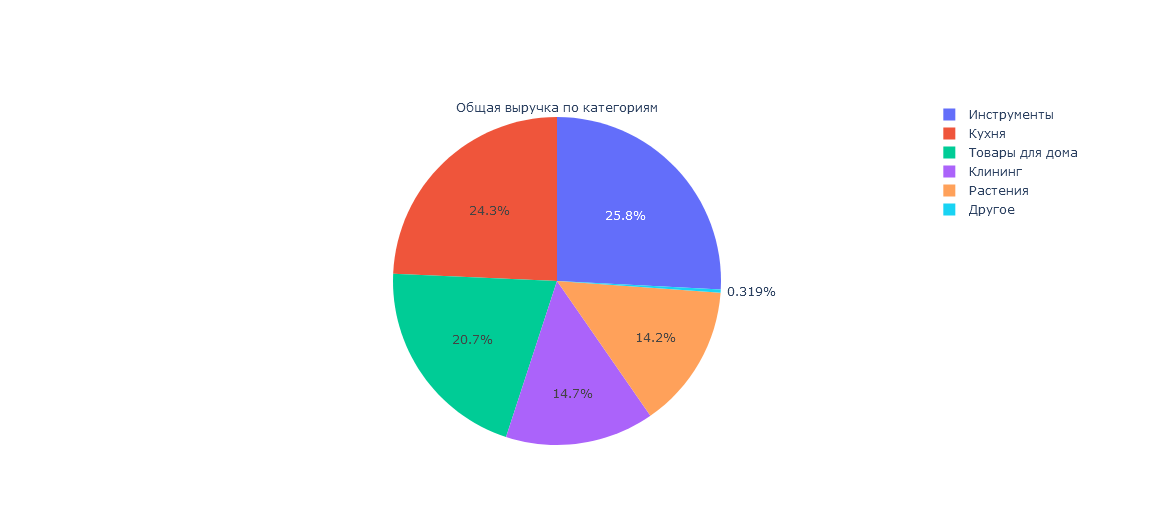

In [55]:
fig = go.Figure(data=[go.Pie(title='Общая выручка по категориям', labels=df.groupby('category')['category'].count().index,values=df.groupby('category')['total'].sum())])
Image.open('/content/newplot(13).png').show()

Больше всего прибыли приносит категория инструменты с <900к, наименее прибыльная - растения (<500к)

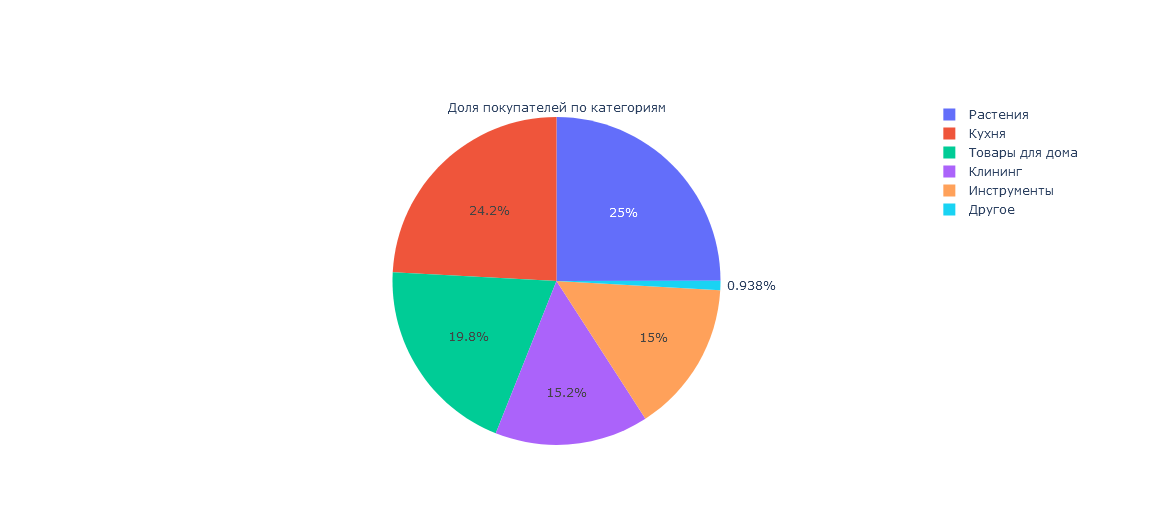

In [56]:
fig = go.Figure(data=[go.Pie(title='Доля покупателей по категориям', labels=df.groupby('category')['category'].count().index,values=df.groupby('category')['customer_id'].nunique())])
Image.open('/content/newplot(14).png').show()

Больше всего покупателей в категории растения (639), меньше всего в инструментах (383).

### Создание кластеров

In [28]:
a=customers.query('order_id>2')
o=customers.query('quantity>10')

In [29]:
y=customers['total'].median()
print('Медианный чек пользователя:',y)
below=df.query('total<@y*.60 & customer_id not in @a.index & customer_id not in @o.index')
below_elite=df.query('total<@y*.60 & customer_id in @a.index & customer_id not in @o.index')
average=df.query('total>@y*.60 & total<@y*1.4 & customer_id not in @a.index & customer_id not in @o.index')
average_elite=df.query('total>@y*.60 & total<@y*1.4 & customer_id in @a.index & customer_id not in @o.index')
above=df.query('total>@y*1.4 & customer_id not in @a.index & customer_id not in @o.index')
above_elite=df.query('total>@y*1.4 & customer_id in @a.index & customer_id not in @o.index')
opt=df.query('customer_id in @o.index')
print('Количество пользователй с маленьким чеком:',len(below))
print('Количество пользователй с маленьким чеком и большим количеством заказов на покупателя (>2):',len(below_elite))
print('Количество пользователй со средний чеком:',len(average))
print('Количество пользователй со средний чеком и большим количеством заказов на покупателя (>2):',len(average_elite))
print('Количество пользователй с большим чеком:',len(above))
print('Количество пользователй с большим чеком и большим количеством заказов на покупателя (>2):',len(above_elite))
print('Количество пользователй-оптовиков (более 10 предметов в заказе):',len(opt))

Медианный чек пользователя: 712.0
Количество пользователй с маленьким чеком: 2823
Количество пользователй с маленьким чеком и большим количеством заказов на покупателя (>2): 260
Количество пользователй со средний чеком: 693
Количество пользователй со средний чеком и большим количеством заказов на покупателя (>2): 73
Количество пользователй с большим чеком: 734
Количество пользователй с большим чеком и большим количеством заказов на покупателя (>2): 91
Количество пользователй-оптовиков (более 10 предметов в заказе): 132


Создано семь кластеров пользователей по таким показателям: 
1. Средний чек кластера меньше среднего чека реди всех пользователей на 40% и количество заказов меньше 3
2. Средний чек кластера меньше среднего чека реди всех пользователей на 40% и количество заказов больше 2
3. Средний чек от 0.6 общего до 1.4 общего и количество заказов меньше 3
4. Средний чек от 0.6 общего до 1.4 общего и количество заказов больше 2
5. Выше 1.4 от общего чека и количество заказов меньше 3
6. Выше 1.4 от общего чека и количество заказов больше 2
7. Оптовики с более чем 10 предметами в заказе

In [30]:
totals=[below['total'].sum(),below_elite['total'].sum(),average['total'].sum(),average_elite['total'].sum(),\
        above['total'].sum(),above_elite['total'].sum(),opt['total'].sum()]
labels=['Мелкий чек','Мелкий чек, много заказов','Средний чек','Средний чек, много заказов',\
        'Крупный чек','Крупный чек, много заказов','Оптовики']

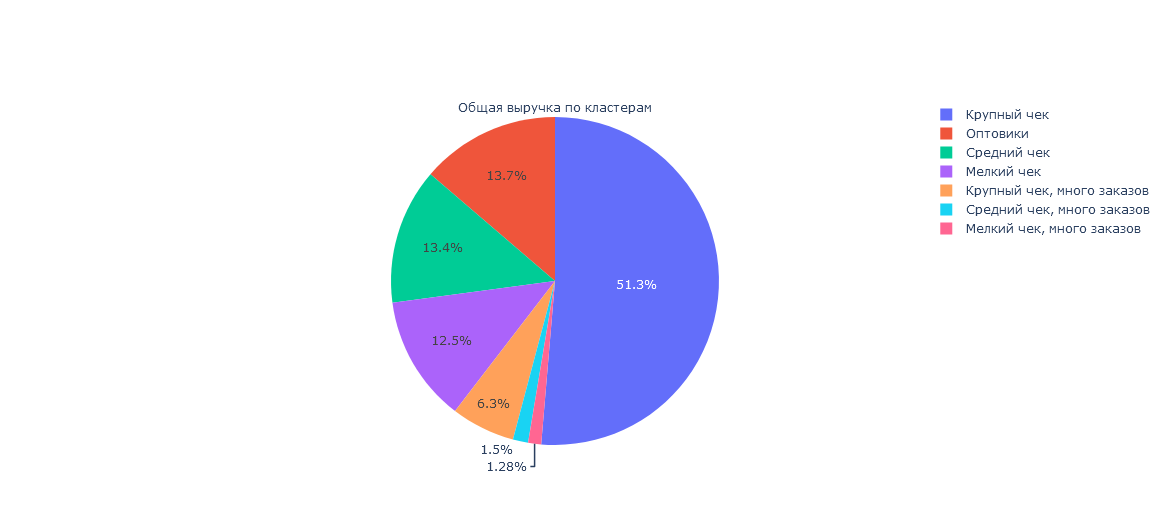

In [57]:
fig = go.Figure(data=[go.Pie(title='Общая выручка по кластерам', labels=labels, values=totals)])
Image.open('/content/newplot(15).png').show()

### Кластер "below"

In [32]:
below.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Растения,1847
Кухня,445
Товары для дома,337
Клининг,118
Инструменты,44
Другое,32


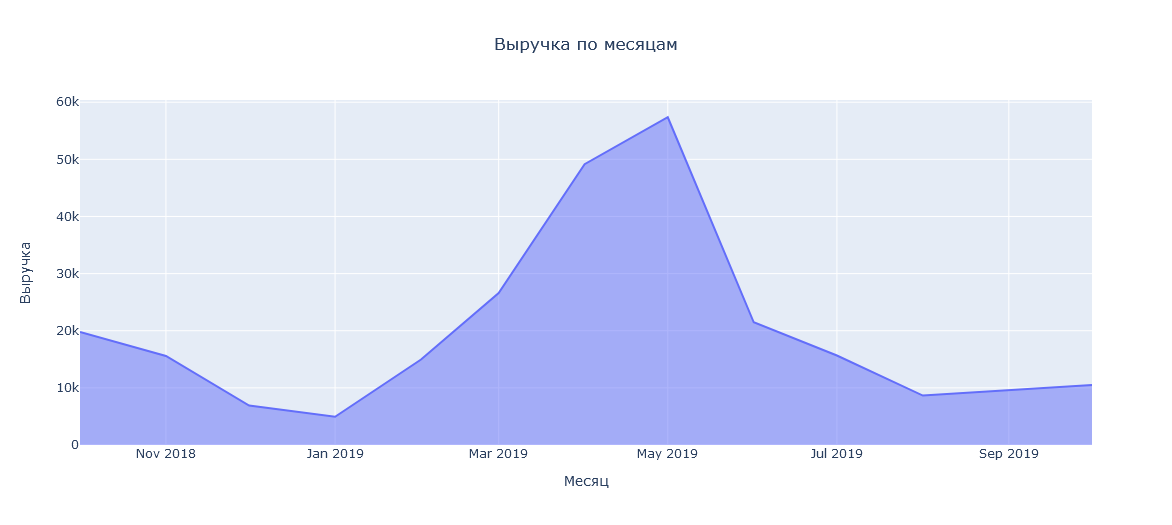

In [58]:
grouped_by_date = below.query('category=="Растения"').groupby('month')\
.agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
            'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(16).png').show()

### Кластер "below_elite"

In [34]:
below_elite.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Растения,180
Кухня,32
Товары для дома,21
Клининг,14
Инструменты,8
Другое,5


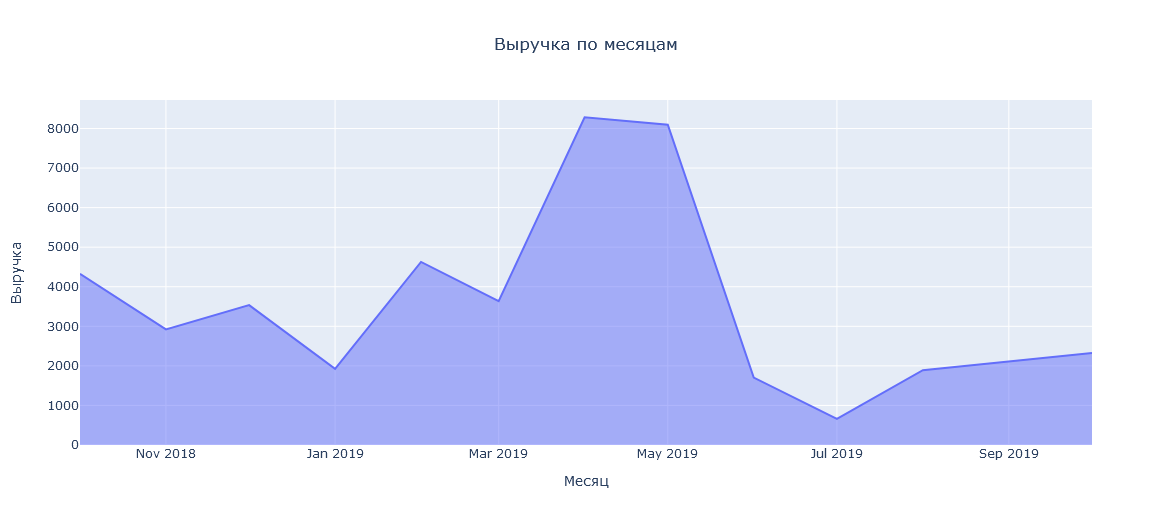

In [59]:
grouped_by_date = below_elite.groupby('month').agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
            'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(17).png').show()

### Кластер "average"

In [36]:
average.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Кухня,195
Клининг,181
Товары для дома,126
Растения,101
Инструменты,88
Другое,2


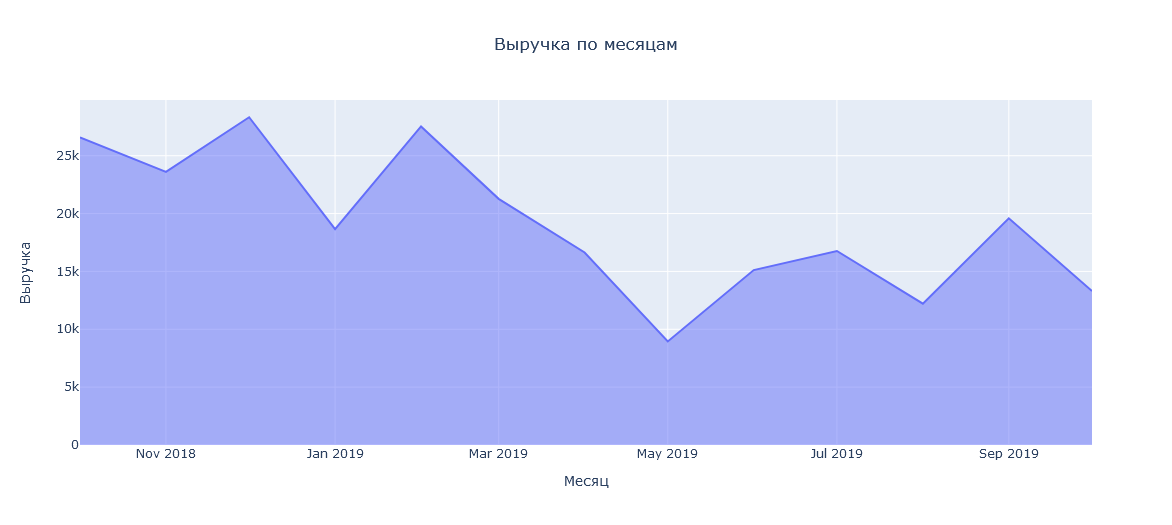

In [60]:
grouped_by_date = average.query('category=="Кухня"|category=="Клининг"')\
.groupby('month').agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(18).png').show()

### Кластер "average_elite"

In [38]:
average_elite.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Кухня,29
Клининг,25
Инструменты,7
Товары для дома,7
Растения,5


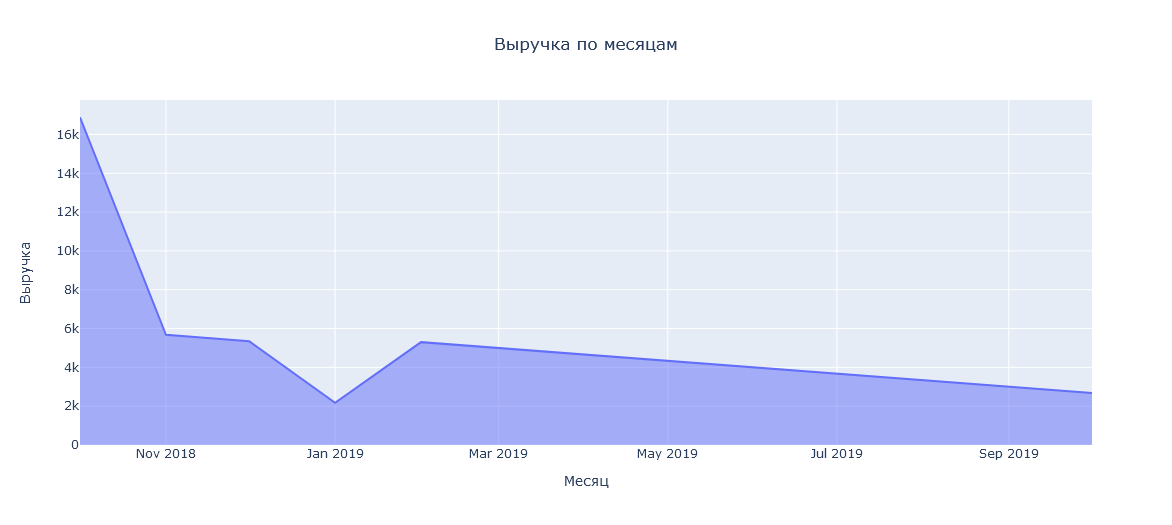

In [61]:
grouped_by_date = average_elite.query('category=="Кухня"|category=="Клининг"')\
.groupby('month').agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
                'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(19).png').show()

### Кластер "above"

In [40]:
above.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Инструменты,248
Кухня,216
Товары для дома,118
Клининг,106
Растения,44
Другое,2


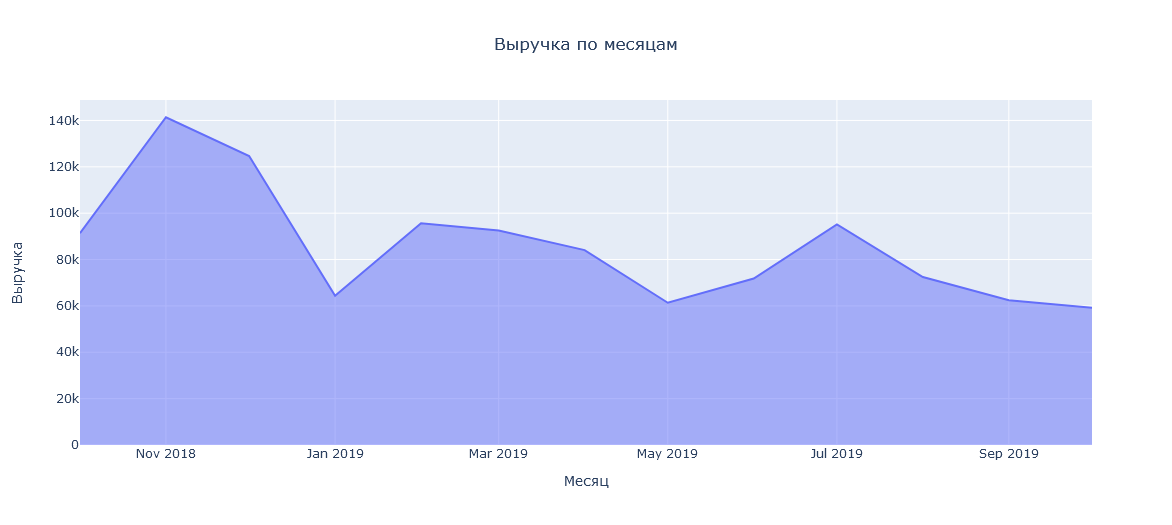

In [62]:
grouped_by_date = above.query('category== "Инструменты"|category=="Кухня"').groupby('month').agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
                'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(20).png').show()

### Кластер "above_elite"

In [42]:
above_elite.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Инструменты,35
Клининг,19
Кухня,17
Растения,10
Товары для дома,10


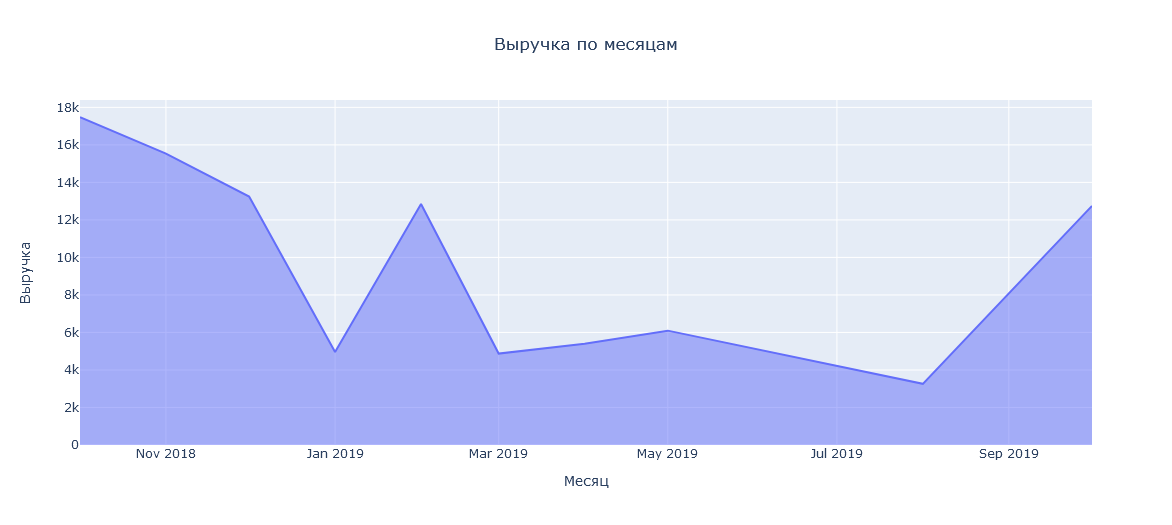

In [63]:
grouped_by_date = above_elite.query('category== "Инструменты"').\
groupby('month').agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
                'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(21).png').show()

### Кластер "opt"

In [44]:
opt.pivot_table(index='category',values='total',aggfunc='count').sort_values(by='total',ascending =False)

,total
category,
Товары для дома,64
Инструменты,22
Кухня,22
Растения,13
Клининг,9
Другое,2


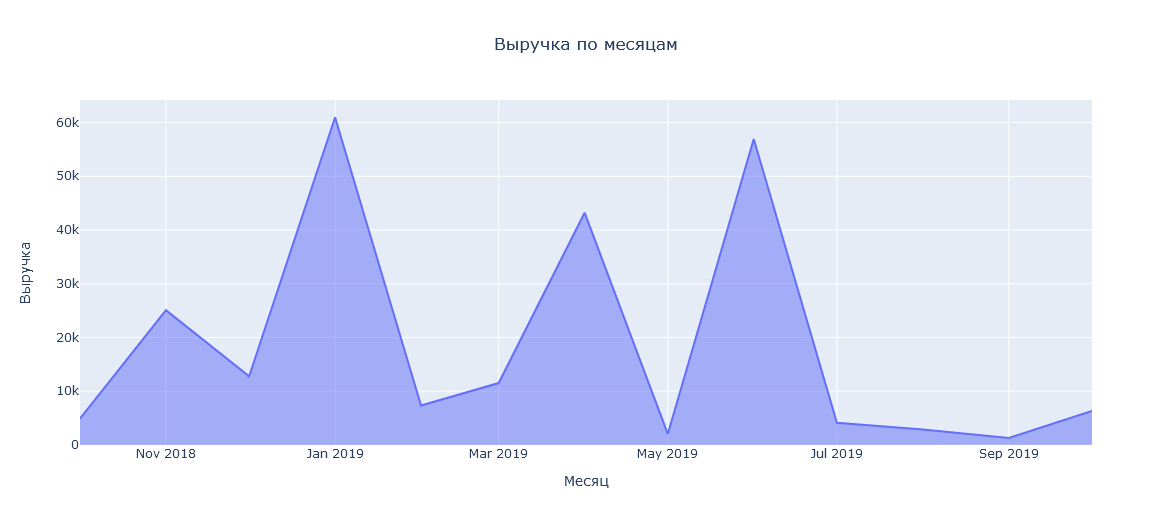

In [64]:
grouped_by_date = opt.query('category=="Товары для дома"').groupby('month').agg({'customer_id':'nunique', 'total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Выручка по месяцам",
                'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка",
    xaxis_title="Месяц")
Image.open('/content/newplot(22).png').show()

### Выводы по кластерам:

Количество пользователей кластере below: 2823, самая покупаемая категория - Растения (1847), наименее покупаемая - Инструменты. Есть выраженная сезонность, пик продаваемости: март-июль, так как товары летние и становятся актуальны к этому сезону.

Количество пользователей в кластере below_elite: 260, самая покупаемая категория - Растения (180), наименее покупаемая - Инструменты. Есть выраженная сезонность, пик продаваемости: март-июль, так как товары летние и становятся актуальны к этому сезону.

Количество пользователей в кластере average: 693, самая покупаемая категория - Кухня (195) и Клининг (181), наименее покупаемая - Инструменты. Сезонность выражена слабее, но продажи уменьшены с мая по октябрь

Количество пользователей в кластере average_elite: 73, самая покупаемая категория - Кухня (29) и Клининг (25), наименее покупаемая - Растения. Сезонность выражена слабее, но продажи уменьшены с мая по октябрь

Количество пользователей в  кластере above: 734, самая покупаемая категория - Инструменты (248) и Кухня (216), наименее покупаемая - Растения. Пик продаж - ноябрь-декабрь, в остальное время продажи примерно одинаковы.

Количество пользователей в кластере above_elite: 91, самая покупаемая категория - Инструменты (35), наименее покупаемая - Товары для дома и Растения. Пик продаж - ноябрь-декабрь, в остальное время продажи примерно одинаковы.

Количество пользователей в кластере opt: 132, самая покупаемая категория - Товары для дома (64), наименее покупаемая - Клининг. Сезонности нет.

## Формирование и проверка гипотез

### Проверяем на нормальность распределения средних:

In [46]:
be=below['total'].tolist()
av=average['total'].tolist()
ab=above['total'].tolist()
be_elite=below_elite['total'].tolist()
av_elite=average_elite['total'].tolist()
ab_elite=above_elite['total'].tolist()
op=opt['total'].tolist()
test=[be,av,ab,be_elite,av_elite,ab_elite,op]

In [47]:
alpha = 0.05  # критический уровень статистической значимости

for x in test:
    results = st.shapiro(x)
    p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    print('================')

p-значение:  1.6499279361491636e-37
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  3.723600246568451e-16
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  3.427236929510136e-39
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  1.0271954998825744e-13
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  0.011341187171638012
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  9.317825677701563e-11
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  1.769235447998217e-20
Отвергаем нулевую гипотезу: распределение не нормально


Данные распределены ненормально, используем критерий Манна-Уитни.

### Средний чек между кластерами не различается

H0 - нет различий между средним чеком среди кластеров

In [48]:
alpha = alpha / 12
results = st.mannwhitneyu(be,av)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(be,ab)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(ab,av)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(be_elite,av_elite)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(be_elite,ab_elite)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(ab_elite,av_elite)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
for x in range(len(test)-1):
    results = st.mannwhitneyu(test[x],op)
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.0
Отвергаем нулевую гипотезу
p-значение:  0.0
Отвергаем нулевую гипотезу
p-значение:  1.9321143394710468e-234
Отвергаем нулевую гипотезу
p-значение:  5.261711588201401e-39
Отвергаем нулевую гипотезу
p-значение:  8.231759137405365e-46
Отвергаем нулевую гипотезу
p-значение:  4.242763467214108e-28
Отвергаем нулевую гипотезу
p-значение:  5.811156637588696e-79
Отвергаем нулевую гипотезу
p-значение:  1.037692060716775e-25
Отвергаем нулевую гипотезу
p-значение:  0.11397272361963724
Не получилось отвергнуть нулевую гипотезу
p-значение:  3.1473280728414733e-54
Отвергаем нулевую гипотезу
p-значение:  1.1591840569953768e-10
Отвергаем нулевую гипотезу
p-значение:  0.23734140221567324
Не получилось отвергнуть нулевую гипотезу


Среди кластеров средний чек отличается.

### Количество товаров в заказе между кластерами не различается

H0 - нет различий между количеством товаров в заказе между кластерами

In [49]:
be=below['quantity'].tolist()
av=average['quantity'].tolist()
ab=above['quantity'].tolist()
be_elite=below_elite['quantity'].tolist()
av_elite=average_elite['quantity'].tolist()
ab_elite=above_elite['quantity'].tolist()
op=opt['quantity'].tolist()
test=[be,av,ab,be_elite,av_elite,ab_elite,op]

for x in test:
    results = st.shapiro(x)
    p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    print('================')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  8.339925901321652e-40
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  1.3329072255612401e-28
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  2.3172471428668795e-13
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  1.0600815031053969e-17
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  2.5175014468382945e-18
Отвергаем нулевую гипотезу: распределение не нормально


In [50]:
alpha = alpha / 12
results = st.mannwhitneyu(be,av)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(be,ab)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(ab,av)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(be_elite,av_elite)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(be_elite,ab_elite)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
    
results = st.mannwhitneyu(ab_elite,av_elite)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
        ) 
for x in range(len(test)-1):
    results = st.mannwhitneyu(test[x],op)
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу')

p-значение:  8.463166369986759e-10
Отвергаем нулевую гипотезу
p-значение:  0.3873883673126759
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.00017527628594869987
Отвергаем нулевую гипотезу
p-значение:  0.010913963594114354
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.16082254499381787
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.4872184000471518
Не получилось отвергнуть нулевую гипотезу
p-значение:  2.564931291934231e-154
Отвергаем нулевую гипотезу
p-значение:  1.2823349306221193e-90
Отвергаем нулевую гипотезу
p-значение:  6.8042502296571495e-105
Отвергаем нулевую гипотезу
p-значение:  1.5957300614862553e-64
Отвергаем нулевую гипотезу
p-значение:  1.0764503220553896e-29
Отвергаем нулевую гипотезу
p-значение:  1.1565406034982931e-28
Отвергаем нулевую гипотезу


Среди кластеров количество товаров в заказе одинаково, кроме кластера с оптовиками.

## Вывод

Был проведён исследовательский анализ данных, в ходе которого выявлено, что покупателей - 2450 и заказов - 2783. То есть чаще всего покупатель совершает разовую покупку на и не возвращается в магазин. Чаще всего заказ содержит 1 предмет, средняя цена - 777 у.е., средний чек - 1488. Присутствует выброс в виде покупателя, купившего 1000 вантузов на 600000.

Средний чек покупателя - 1690. Аномально частыми посетителями считаются посетители, совершившие более 3 покупок или на сумму более 8784 у.е. Частых покупателей 8, потратившихся - 25. Дальнейшие данные очищены от аномалий. 

Далее товары были разделены на 5 категорий, не считая "Другое": Растения, Товары для дома, Инструменты, Клининг и Товары для кухни. Самая большая категория: "Растения" с 2219 товарами, наименьшая - "Инструменты" с 462 товаром. Средняя цена за одну единицу товара примерно равна во всех категориях, кроме инструментов и клининга (1087 и 569).
Больше всего прибыли приносит категория инструменты с >900к, наименее прибыльная - растения (<500к)
Больше всего покупателей в категории растения (652), меньше всего в инструментах (393).

Обратить внимание необходимо на факт, что покупатели крайне редко совершают более одной покупки, то есть необходимо принять меры для удержания клиентов. Несмотря на то, что растения являются самой популярной категорией по покупкам, по количеству прибыли она занимает последнее место. Самая прибыльная категория - Инструменты с наибольшим оборот и с наименьшим количеством клиентов, что говорит о том, что каждый отдельный клиент для магазина тратит большие суммы на покупки инструмента.

## Рекомендации по кластерам:

Созданы семь кластеров пользователей по нескольким параметрам:


    Средний чек кластера меньше среднего чека реди всех пользователей на 40% и количество заказов меньше 3
    Средний чек кластера меньше среднего чека реди всех пользователей на 40% и количество заказов больше 2
    Средний чек от 0.6 общего до 1.4 общего и количество заказов меньше 3
    Средний чек от 0.6 общего до 1.4 общего и количество заказов больше 2
    Выше 1.4 от общего чека и количество заказов меньше 3
    Выше 1.4 от общего чека и количество заказов больше 2
    Оптовики с более чем 10 предметами в заказе


Количество пользователей кластере below: 2823, самая покупаемая категория - Растения (1847), наименее покупаемая - Инструменты. Есть выраженная сезонность, пик продаваемости: март-июль, так как товары летние и становятся актуальны к этому сезону.

Количество пользователей в кластере below_elite: 260, самая покупаемая категория - Растения (180), наименее покупаемая - Инструменты. Есть выраженная сезонность, пик продаваемости: март-июль, так как товары летние и становятся актуальны к этому сезону.

Количество пользователей в кластере average: 693, самая покупаемая категория - Кухня (195) и Клининг (181), наименее покупаемая - Инструменты. Сезонность выражена слабее, но продажи уменьшены с мая по октябрь

Количество пользователей в кластере average_elite: 73, самая покупаемая категория - Кухня (29) и Клининг (25), наименее покупаемая - Растения. Сезонность выражена слабее, но продажи уменьшены с мая по октябрь

Количество пользователей в кластере above: 734, самая покупаемая категория - Инструменты (248) и Кухня (216), наименее покупаемая - Растения. Пик продаж - ноябрь-декабрь, в остальное время продажи примерно одинаковы.

Количество пользователей в кластере above_elite: 91, самая покупаемая категория - Инструменты (35), наименее покупаемая - Товары для дома и Растения. Пик продаж - ноябрь-декабрь, в остальное время продажи примерно одинаковы.

Количество пользователей в кластере opt: 132, самая покупаемая категория - Товары для дома (64), наименее покупаемая - Клининг. Сезонности нет.

Рекомендации по кластеру с маленьким чеком: так как в нём преобладает дешёвая категория Растения и покупок в этой категории очень много, хоть и по низкой цене, рекомендуется увеличить цены на товар, кластер содержит много покупателей, поэтому увеличение цены на товар положительно скажется на выручке магазина. Наилучшее время для рассылки рекламных предложений - весна - начало лета, но она не окупится в этом кластере, так как каждый уникальный покупатель совершает заказ на маленькую сумму, и рассылка будет невыгодна.

Рекомендации по кластеру с маленьким чеком и частыми заказами: аналогичны кластеру выше, за исключением окупаемости рекламной рассылки, для покупателей этого кластера она будет выгодна, ведь они совершают частые покупки.

Кластер со средний чеком: продажи практически не зависят от сезона, рассылку можно совершать в любое время, рекламируемыми товарами должны быть товары категории Кухня и Клининг, не приоритетный кластер.

Кластер со средний чеком и частыми заказами: аналогичны кластеру выше, кроме приоритетности, рекламная рассылка будет выгодна и этот кластер более приоритетен.

Кластер с наибольшим средний чеком: нужно увеличить количество продаваемого товара в этой кластере, так как основная категория в кластере - Инструменты, имеющие самую дорогую среднюю цену за штуку (1000 у.е.). Покупатели инструментов - самые прибыльные и нужные магазину. Увеличение их возвращаемости очень важно для магазина и прибыли. Рекламная рассылка будет наиболее выгодна в этом кластере, лучшее время - ноябрь-декабрь.

Кластер с наибольшим средний чеком и частыми заказами: аналогично кластеру выше, но ценность клиентов ещё больше, топ-2 кластер по приоритетности, наибольшая окупаемость рекламы.

Кластер с оптовиками: прибыльный кластер благодаря большому количеству товаров в корзине, увеличение возвращаемости клиентов необходимо для этого кластера, также как и рекламная рассылка в категории Товары для дома, покупки не зависят от сезона.